Enter your SentinelHub client id ········
Enter your SentinelHub client secret ········


/tmp/ipykernel_1961/1193290186.py:188: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  milan_gdf["area"] = milan_gdf.geometry.area


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (893, 1689, 3)
Image type: uint8


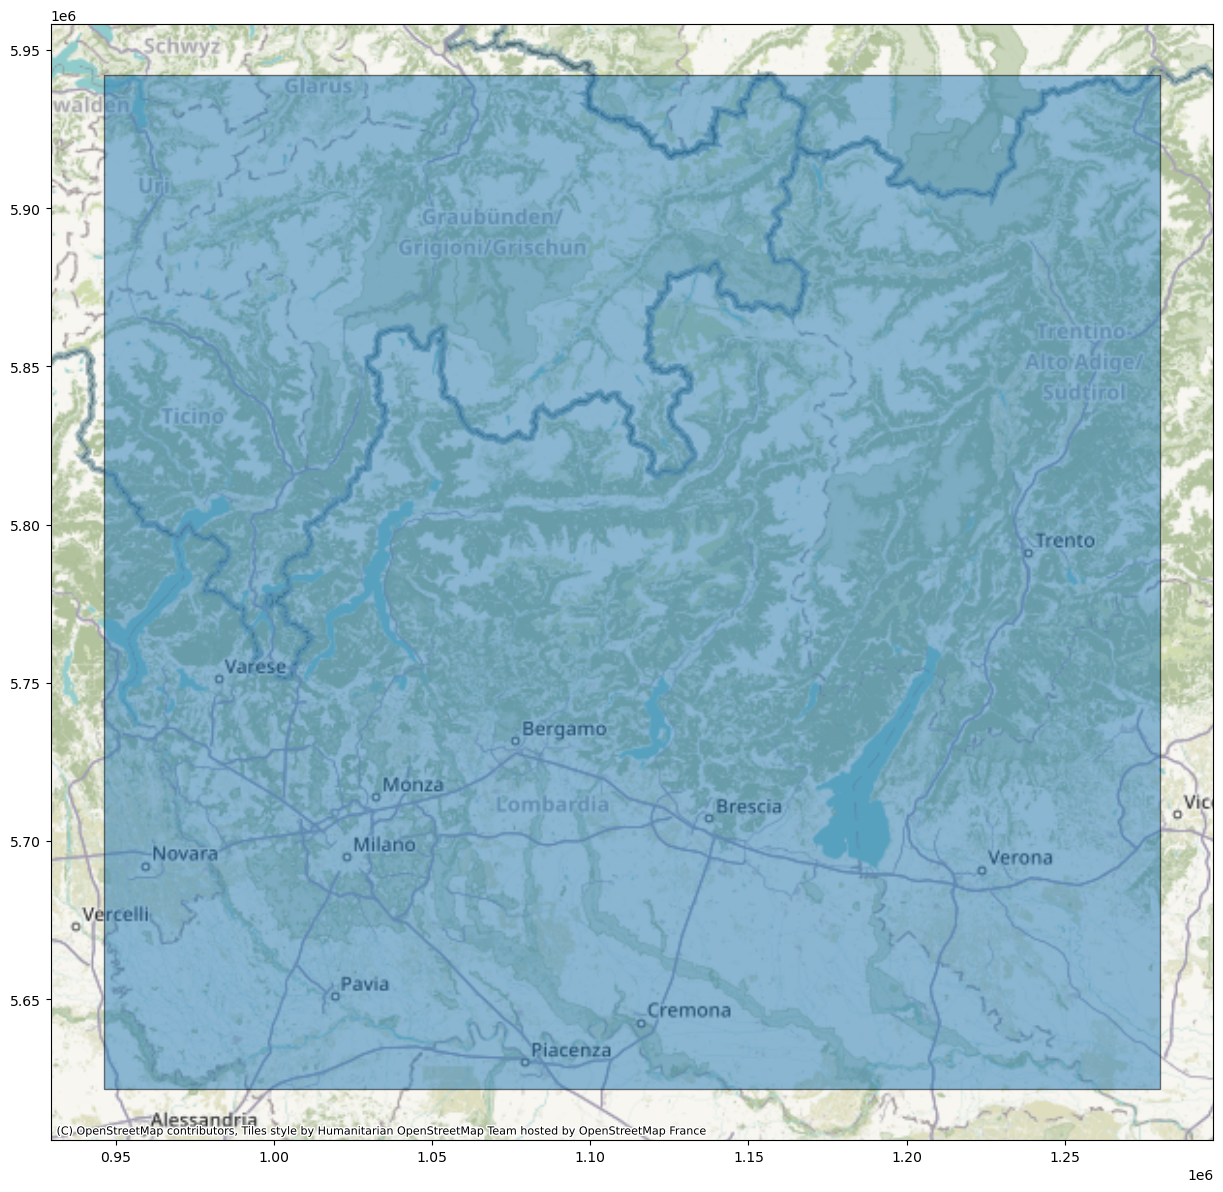

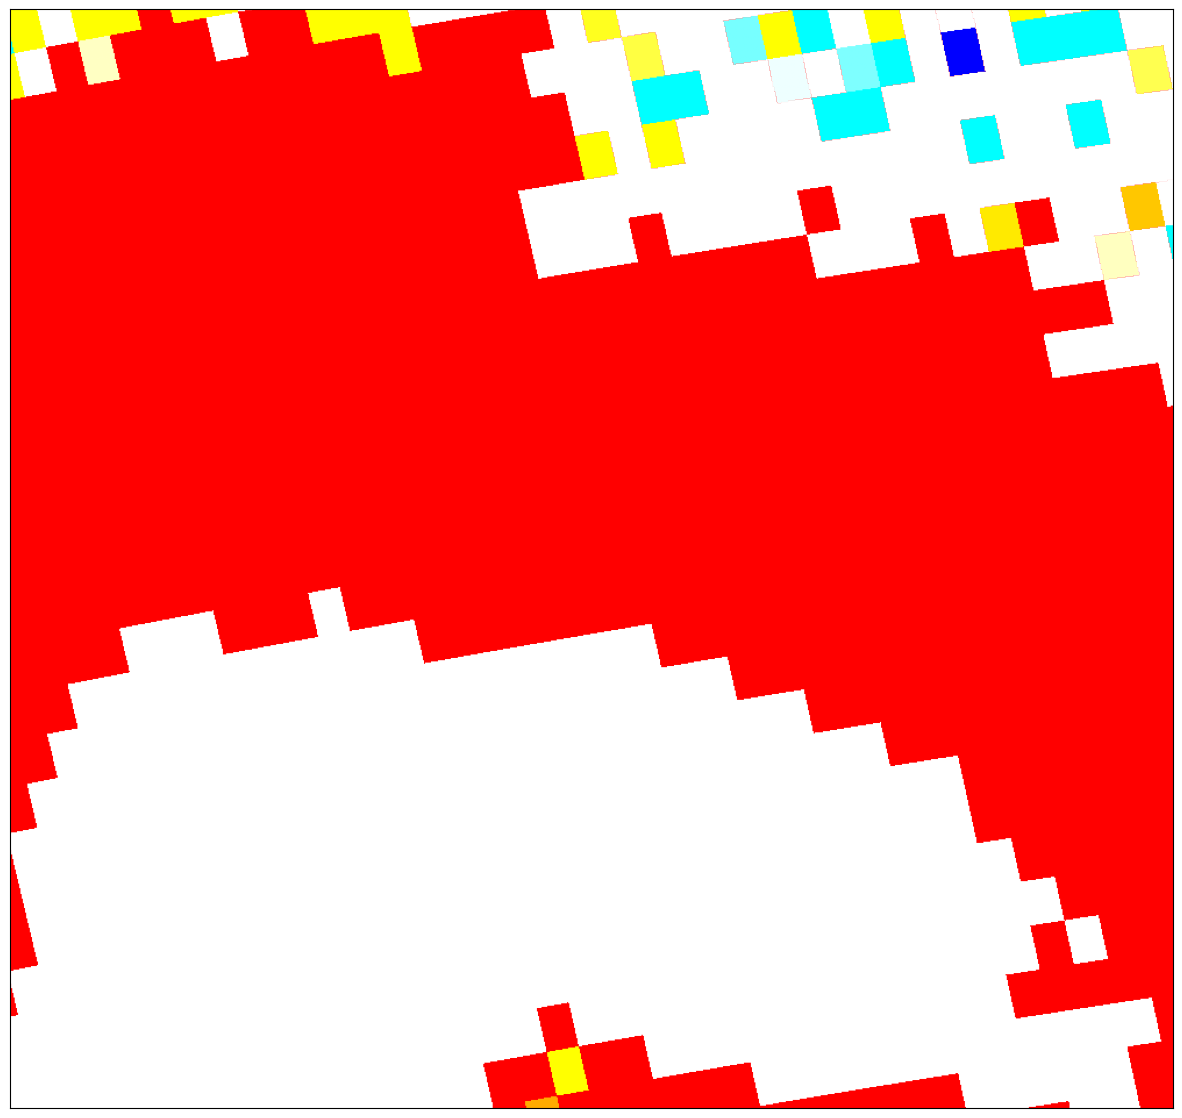

In [3]:
# import sys
# !{sys.executable} -m pip install contextily

# Utilities
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Any, Optional, Tuple

import geopandas as gpd
import contextily as cx

import getpass

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
    parse_time,
)


# define functions to extract statistics for all acquisition dates
def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data['outputs'].items():
        stats = value['bands']['B0']['stats']
        if stats['sampleCount']==stats['noDataCount']:
            continue
        else:
            d['date'] = [date]
            for stat_name, stat_value in stats.items():
                if (stat_name=='sampleCount' or stat_name=='noDataCount'):
                    continue
                else:
                    d[f'{key}_{stat_name}'] = [stat_value]
    return pd.DataFrame(d)

def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq['interval']['from'][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)

def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

# Only run this cell if you have not created a configuration.

config = SHConfig()
config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

config = SHConfig("cdse")


evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""


geometry = Geometry(geometry={"type":"Polygon","coordinates":[[[4.232112,50.934173],[4.569817,50.937635],[4.56158,50.75902],[4.240348,50.762495],[4.232112,50.934173]]]}, crs=CRS.WGS84)

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2022-05-01", "2022-05-20"),
            other_args={"dataFilter": {"mosaickingOrder": "leastRecent"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    geometry=geometry,
    resolution=(0.0002,0.0002),
    config=config,
)

true_color_imgs = request_true_color.get_data()

milan_aoi="""{
  "type": "Polygon",
  "coordinates": [
    [
      [
        8.5,
        45
      ],
      [
        11.5,
        45,
      ],
      [
        11.5,
        47
      ],
      [
        8.5,
        47
      ],
      [
        8.5,
        45
      ]
    ]
  ]
}
"""

# Read the land cover samples into a GeoDataFrame
milan_gdf = gpd.read_file(milan_aoi)

# Calculate the area for each geometry and add it as a new column
milan_gdf["area"] = milan_gdf.geometry.area

milan_gdf_wm = milan_gdf.to_crs(epsg=3857)

# Explore the GeoDataFrame, visualizing the 'area' column with a specified colormap
ax = milan_gdf_wm.plot(alpha=0.5, edgecolor="k", figsize = (15,15))
cx.add_basemap(ax)

geometry = Geometry(geometry={"type": "Polygon","coordinates": [[[8.5,44.5],[10.5,45],[10,46],[8.5,46],[8.5,45]]]}, crs=CRS.WGS84)

evalscript = """//VERSION=3
function setup() {
return {
input: ["NO2", "dataMask"],
output: { bands: 4 },
}
}

const minVal = 0.0
const maxVal = 0.0001
const diff = maxVal - minVal

const rainbowColors = [
[minVal, [0, 0, 0.5]],
[minVal + 0.125 * diff, [0, 0, 1]],
[minVal + 0.375 * diff, [0, 1, 1]],
[minVal + 0.625 * diff, [1, 1, 0]],
[minVal + 0.875 * diff, [1, 0, 0]],
[maxVal, [0.5, 0, 0]],
]

const viz = new ColorRampVisualizer(rainbowColors)

function evaluatePixel(sample) {
var rgba = viz.process(sample.NO2)
rgba.push(sample.dataMask)
return rgba
}
"""

bbox = BBox(bbox=[8.485304, 44.879167, 10.313724, 46.103649], crs=CRS.WGS84)

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL5P.define_from(
                name="s5p", service_url="https://sh.dataspace.copernicus.eu"
            ),          
            time_interval=('2024-12-01', '2024-12-12'),          
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG),
    ],
    bbox=bbox,
    size=[1000, 945.119],
    config=config
)

response = request.get_data()

sen5p_viz = request.get_data()
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)
image = sen5p_viz[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))



/tmp/ipykernel_1961/4284206027.py:86: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons_gdf["area"] = polygons_gdf.geometry.area
/opt/conda/envs/sentinelhub/lib/python3.10/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 25 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


Enter your SentinelHub client id:  ········
Enter your SentinelHub client secret:  ········


/opt/conda/envs/sentinelhub/lib/python3.10/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)
/opt/conda/envs/sentinelhub/lib/python3.10/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/opt/conda/envs/sentinelhub/lib/python3.10/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/opt/conda/envs/sentinelhub/lib/python3.10/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLim

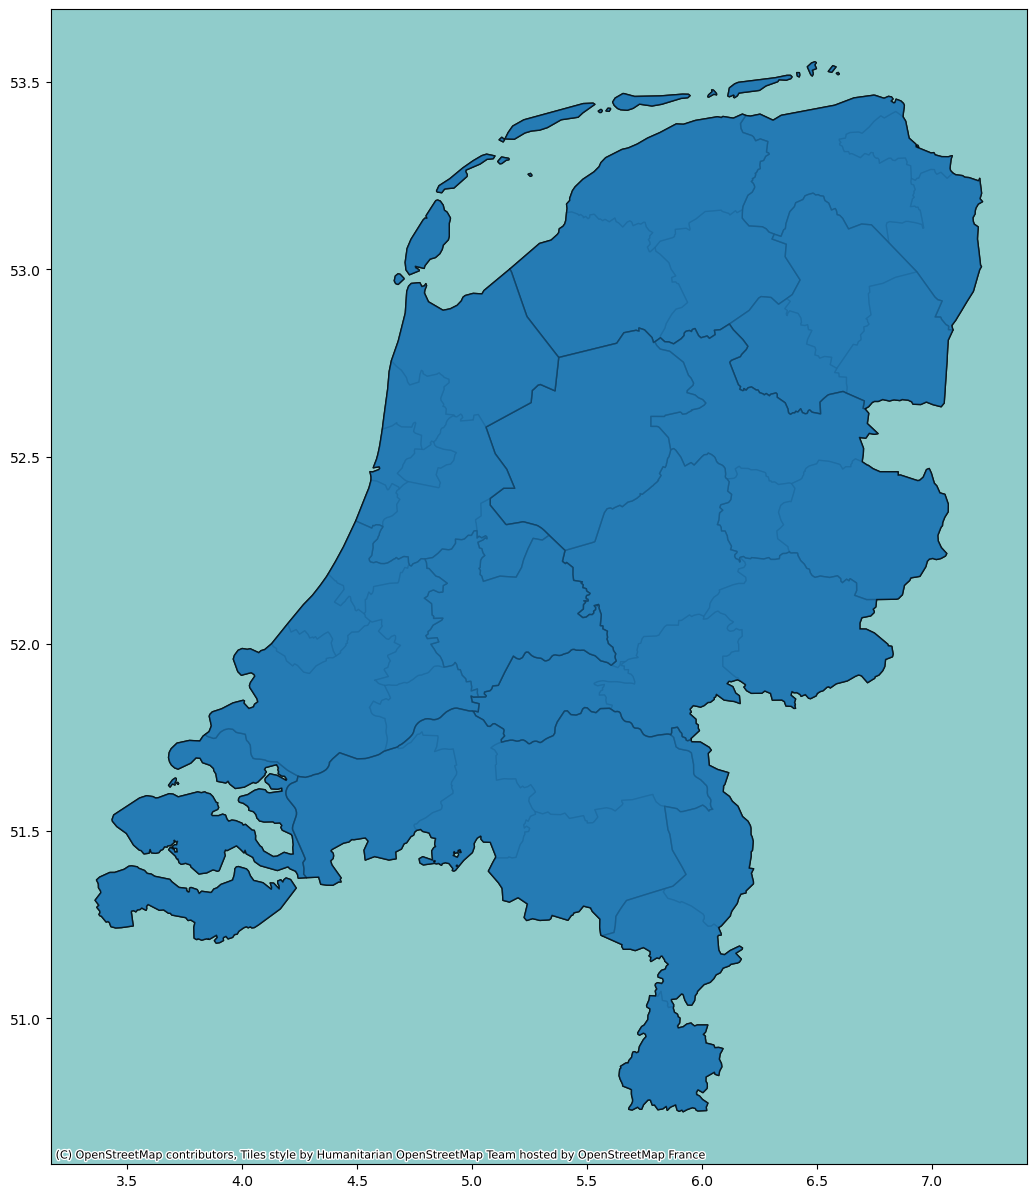

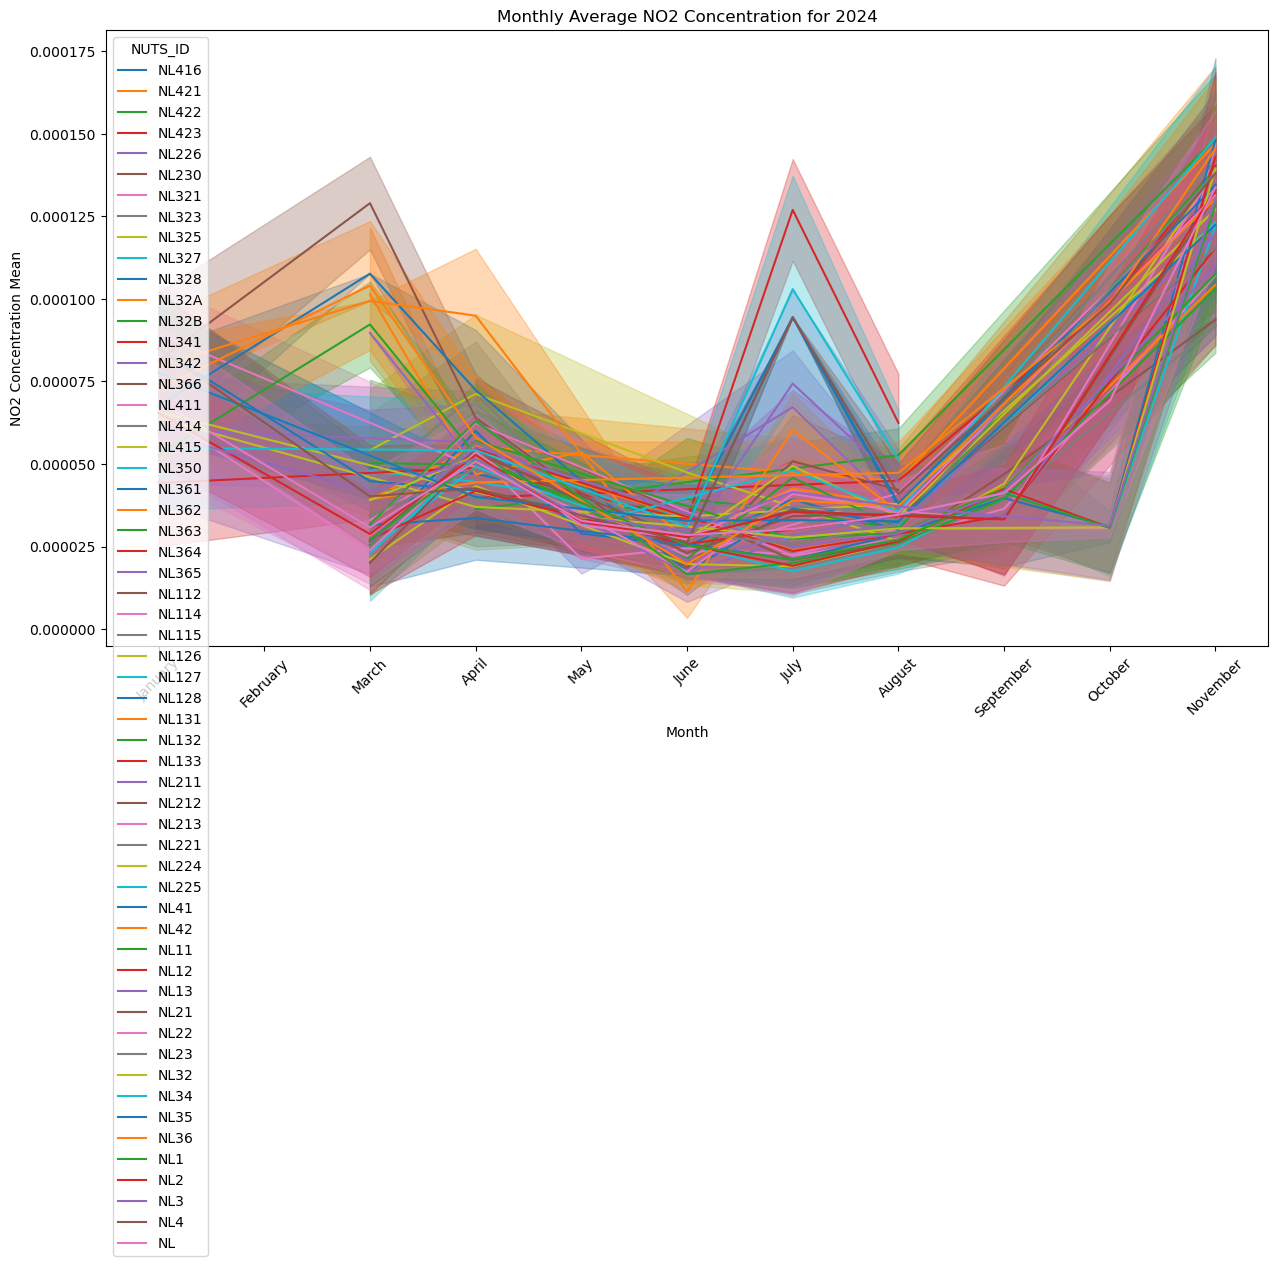

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import contextily as cx
import calendar
import getpass
from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    CRS,
    Geometry,
    parse_time,
)

# =============================================================================
# Helper Functions
# =============================================================================
def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame."""
    df_data = []
    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True
        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()
        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break
                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value
        if is_valid_entry:
            df_data.append(df_entry)
    return pd.DataFrame(df_data)

# =============================================================================
# Define the NO2 evalscript for the Statistical API
# =============================================================================
no2_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["NO2", "dataMask"],
    output: [
      {
        id: "no2",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  };
}

function evaluatePixel(sample) {
  return {
    no2: [sample.NO2],
    dataMask: [sample.dataMask]
  };
}
"""

# =============================================================================
# Load the Shapefile (polygons) and Prepare the GeoDataFrame
# =============================================================================
# Change the file name if needed (e.g., "NUTS_NL_01m_2024.shp")
polygons_gdf = gpd.read_file("NUTS_NL_01m_2024.shp")
# Ensure the coordinate system is WGS84
if polygons_gdf.crs.to_string() != "EPSG:4326":
    polygons_gdf = polygons_gdf.to_crs(epsg=4326)
# Add area column (optional)
polygons_gdf["area"] = polygons_gdf.geometry.area

# Visualize the polygons
ax = polygons_gdf.plot(alpha=0.5, edgecolor="k", figsize=(15,15))
cx.add_basemap(ax)

# =============================================================================
# Set Up Sentinel Hub Configuration
# =============================================================================
config = SHConfig()
if not config.sh_client_id or not config.sh_client_secret:
    config.sh_client_id = getpass.getpass("Enter your SentinelHub client id: ")
    config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret: ")
    config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    config.sh_base_url = "https://sh.dataspace.copernicus.eu"
    config.save("cdse")
config = SHConfig("cdse")

# =============================================================================
# Prepare the Sentinel-5P Input Data for NO2
# =============================================================================
input_data = SentinelHubStatistical.input_data(
    DataCollection.SENTINEL5P.define_from("s5p", service_url=config.sh_base_url)
)

# =============================================================================
# Create Statistical Requests for Each Polygon and Month in 2024
# =============================================================================
no2_requests = []
# This list will hold metadata (NUTS_ID and month info) for later merging
request_info = []

year = 2024
for idx, row in polygons_gdf.iterrows():
    nuts_id = row["NUTS_ID"]
    geom = row.geometry
    for month in range(1, 13):
        # Define start and end dates: use the first day of the month and the first day of the next month
        start_date = pd.Timestamp(year, month, 1)
        if month == 12:
            end_date = pd.Timestamp(year + 1, 1, 1)
        else:
            end_date = pd.Timestamp(year, month + 1, 1)
        
        # Create the aggregation object with the monthly time interval.
        # The aggregation_interval "P1M" tells the API to compute statistics for the entire month.
        aggregation = SentinelHubStatistical.aggregation(
            evalscript=no2_evalscript,
            time_interval=(start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")),
            aggregation_interval="P1M"
        )
        
        # Build the statistical request for the current polygon and month.
        request = SentinelHubStatistical(
            aggregation=aggregation,
            input_data=[input_data],
            geometry=Geometry(geom, crs=CRS(polygons_gdf.crs)),
            config=config,
        )
        no2_requests.append(request)
        request_info.append({
            "NUTS_ID": nuts_id,
            "month": start_date.strftime("%B"),
            "month_num": month
        })

# =============================================================================
# Download the Statistical Data for All Requests
# =============================================================================
client = SentinelHubStatisticalDownloadClient(config=config)
download_requests = [req.download_list[0] for req in no2_requests]
no2_stats = client.download(download_requests)

# =============================================================================
# Process the Downloaded Statistics and Build a DataFrame
# =============================================================================
no2_dfs = []
for stats, info in zip(no2_stats, request_info):
    df = stats_to_df(stats)
    if not df.empty:
        df["NUTS_ID"] = info["NUTS_ID"]
        df["month"] = info["month"]
        df["month_num"] = info["month_num"]
        no2_dfs.append(df)
        
# Combine results from all requests into one DataFrame
no2_df = pd.concat(no2_dfs, ignore_index=True)
no2_df.sort_values(by=["NUTS_ID", "month_num"], inplace=True)

# =============================================================================
# Plot the Monthly NO2 Time Series for Each Polygon
# =============================================================================
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_xlabel("Month")
ax.set_ylabel("NO2 Concentration Mean")
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_order, rotation=45)

# Loop over each unique polygon (by NUTS_ID)
for idx, nuts_id in enumerate(polygons_gdf["NUTS_ID"].unique()):
    series = no2_df[no2_df["NUTS_ID"] == nuts_id].sort_values("month_num")
    ax.plot(series["month_num"], series["no2_B0_mean"], color=f"C{idx}", label=str(nuts_id))
    ax.fill_between(
        series["month_num"],
        series["no2_B0_mean"] - series["no2_B0_stDev"],
        series["no2_B0_mean"] + series["no2_B0_stDev"],
        color=f"C{idx}",
        alpha=0.3,
    )

ax.legend(title="NUTS_ID")
plt.title("Monthly Average NO2 Concentration for 2024")
plt.show()


In [14]:
no2_df

,interval_from,interval_to,no2_B0_min,no2_B0_max,no2_B0_mean,no2_B0_stDev,no2_B0_sampleCount,no2_B0_noDataCount,NUTS_ID,month,month_num
345,2024-01-01,2024-02-01,0.000010,0.000119,0.000069,0.000023,65536,64058,NL,January,1
346,2024-03-01,2024-04-01,0.000001,0.000136,0.000031,0.000017,65536,54834,NL,March,3
347,2024-04-01,2024-05-01,0.000007,0.000112,0.000051,0.000014,65536,41744,NL,April,4
348,2024-05-01,2024-06-01,0.000021,0.000057,0.000033,0.000009,65536,64816,NL,May,5
349,2024-06-01,2024-07-01,-0.000009,0.000100,0.000029,0.000012,65536,58453,NL,June,6
...,...,...,...,...,...,...,...,...,...,...,...
12,2024-11-01,2024-12-01,0.000103,0.000186,0.000149,0.000019,65536,34705,NL422,November,11
13,2024-04-01,2024-05-01,0.000023,0.000060,0.000040,0.000009,65536,26893,NL423,April,4
14,2024-08-01,2024-09-01,0.000032,0.000058,0.000045,0.000007,65536,26835,NL423,August,8
15,2024-10-01,2024-11-01,0.000050,0.000185,0.000099,0.000027,65536,34562,NL423,October,10


In [19]:
# =============================================================================
# Conversion Function (mol/m² to µg/m³)
# =============================================================================
def convert_to_ugm3(value):
    conversion_factor = (46 / 22.4) * 1e6  # Molecular weight (46 g/mol), Molar volume (22.4 m³/mol)
    return value * conversion_factor

# =============================================================================
# Reshape the DataFrame, Convert to µg/m³, Round Values, and Export to CSV
# =============================================================================

# Pivot the DataFrame to have one row per NUTS_ID and statistics for each month as columns
no2_pivot_df = no2_df.pivot_table(
    index="NUTS_ID",
    columns="month_num",
    values=["no2_B0_mean", "no2_B0_max", "no2_B0_min", "no2_B0_stDev"],
    aggfunc="first"
)

# Flatten the MultiIndex columns, rename them to be more descriptive
no2_pivot_df.columns = [f"{stat}_{calendar.month_abbr[month]}" for stat, month in no2_pivot_df.columns]
no2_pivot_df.reset_index(inplace=True)

# Add year column
no2_pivot_df["year"] = year

# Apply the conversion to all columns (NO2 values) and round to 5 decimal places
for col in no2_pivot_df.columns:
    if col.startswith("no2_"):
        no2_pivot_df[col] = no2_pivot_df[col].apply(convert_to_ugm3).round(5)

# Save the DataFrame to a CSV file
csv_filename = "no2_statistics_2024_ugm3.csv"
no2_pivot_df.to_csv(csv_filename, index=False)

print(f"Data successfully saved to {csv_filename} in µg/m³ units.")


Data successfully saved to no2_statistics_2024_ugm3.csv in µg/m³ units.


In [ ]:
# =============================================================================
# Calculate the Annual Mean NO2 Concentration per Polygon
# =============================================================================
# Group by NUTS_ID and calculate the mean of monthly NO2 means
annual_mean_df = no2_df.groupby("NUTS_ID")["no2_B0_mean"].mean().reset_index()

# Add a year column for clarity (since your data is for 2024)
annual_mean_df["year"] = 2024

# =============================================================================
# Compare Against Air Quality Directive Limits
# =============================================================================

# Set the limit values
NO2_ANNUAL_LIMIT = 40  # µg/m³ for 2010 and beyond
NO2_2009_LIMIT = 42    # µg/m³ for the year 2009 (if applicable)

# Compare the calculated annual mean with the limit
# Since your data is for 2024, we use the 40 µg/m³ limit
annual_mean_df["compliance"] = annual_mean_df["no2_B0_mean"].apply(lambda x: "Compliant" if x <= NO2_ANNUAL_LIMIT else "Exceeds Limit")

# Output the polygons that exceed the limit
non_compliant_zones = annual_mean_df[annual_mean_df["compliance"] == "Exceeds Limit"]

# Save the compliance data to a CSV for reporting
csv_filename_compliance = "no2_compliance_2024.csv"
annual_mean_df.to_csv(csv_filename_compliance, index=False)

print(f"Compliance data saved to {csv_filename_compliance}")

# Optionally, display non-compliant zones
if not non_compliant_zones.empty:
    print("Non-compliant zones (Annual Mean exceeds 40 µg/m³):")
    print(non_compliant_zones)
else:
    print("All zones are compliant with the 40 µg/m³ limit for 2024.")
